In [8]:
import sys
from os import path
sys.path.append( path.abspath('..') )

In [9]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from src.model.mask import get_mask_noise
from src.model.dataset import DefaultTransform
from src.model.model import Generator
from src.setup.logging_utils import normalize_image
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import os
import torch

In [10]:
tf = DefaultTransform()
device = torch.device('cuda')

In [11]:
filepath = '../data/test/he/'

In [12]:
files = [file for file in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, file)) and file.endswith('.png')]

In [13]:
images = []
limit = 3000

In [14]:
for file in files:
    try:
        image = Image.open(os.path.join(filepath, file)).convert('RGB')
    except:
        continue
    
    image = tf(image)
    
    images.append(image.unsqueeze(0).to(device))

    if len(images) >= limit:
        break

In [15]:
len(images)

3000

In [16]:
model = torch.load('../data/model_checkpoint_best.pth')
gen = Generator(32, 8).to(device)
gen.load_state_dict(model['generator_he_to_p63_state_dict'])
gen.eval()

Generator(
  (conv1dc): ConvBlock(
    (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv1dm): ConvBlock(
    (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (interpretable_conv_1): ConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (interpretable_conv_2): ConvBlock(
    (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn)

In [17]:
codes = []
tf_images = []
with torch.no_grad():
    for image in images:
        mask = get_mask_noise(image).to(device)
        img = gen(image, mask)
        # resize to 64x64
        img = torch.nn.functional.interpolate(img, size=(64, 64), mode='bilinear', align_corners=False)
        tf_images.append(normalize_image(img))
        code = gen.get_resnet_transformed()
        codes.append(code.detach().cpu().numpy())

In [18]:
tf_images = np.array(tf_images)
#save
np.save('../data/tf_images.npy', tf_images)

In [19]:
codes = np.array(codes).squeeze()

In [20]:
codes_2d = codes.reshape(codes.shape[0], codes.shape[1] * codes.shape[2] * codes.shape[3])

In [21]:
#np.save('../data/codes_2d.npy', codes_2d)

In [22]:
if os.path.isfile('../data/pca_results.npy'):
    pca_results = np.load('../data/pca_results.npy')
else:
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(codes_2d)
    np.save('../data/pca_results.npy', pca_results)

In [14]:
if os.path.isfile('../data/tsne_results.npy'):
    tsne_results = np.load('../data/tsne_results.npy')
else:
    tsne = TSNE(n_components=2, perplexity=60, n_iter=1000, verbose=1)
    tsne_results = tsne.fit_transform(pca_results)
    np.save('../data/tsne_results.npy', tsne_results)

In [17]:
%matplotlib notebook

<IPython.core.display.Javascript object>


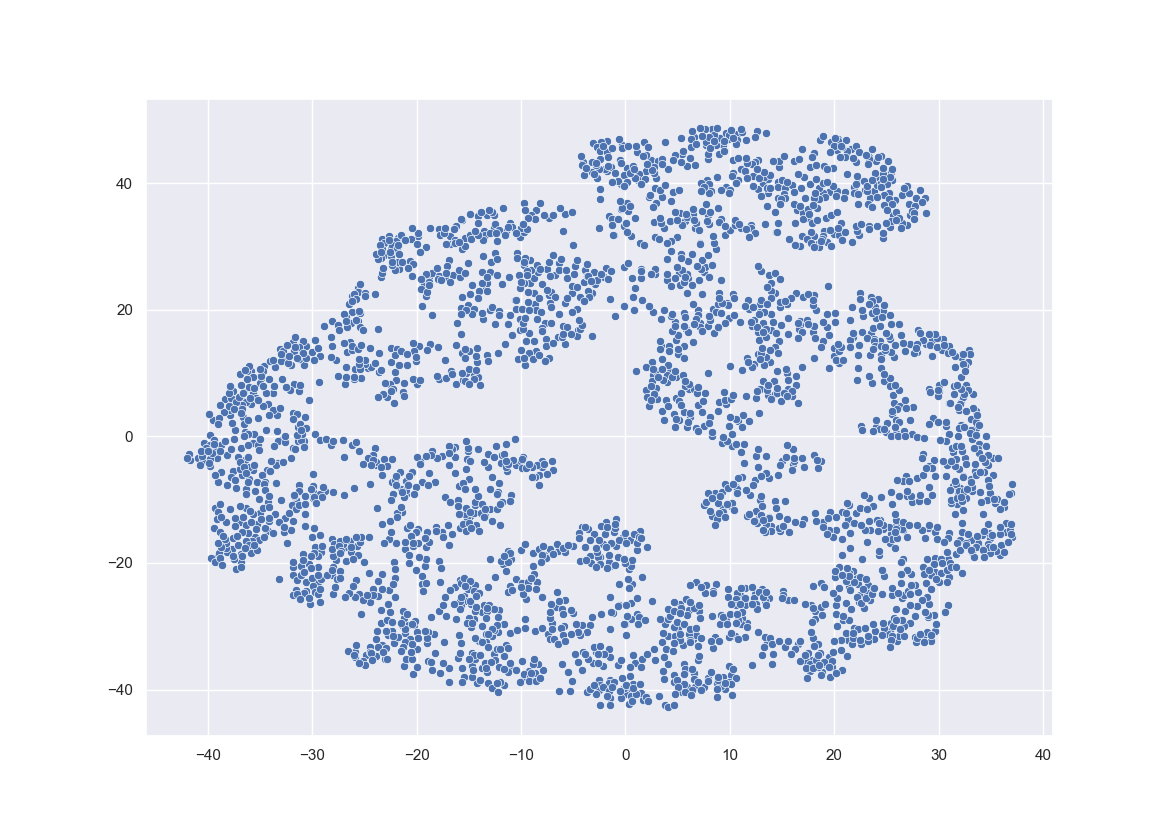

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig = plt.figure()
ax = fig.add_subplot(111)
sns.set(rc={'figure.figsize':(11.7,8.27)})
scatter = sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    picker=4
)

image = normalize_image(images[0])
im = OffsetImage(image, zoom=0.1)
xybox=(50., 50.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)


def hover(event):
    # if the mouse is over the scatter points
    if scatter.contains(event)[0]:
        # find out the index within the array from the event
        ind, = scatter.contains(event)[1]["ind"]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.)
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(tsne_results[ind,0], tsne_results[ind,1])
        # set the image corresponding to that point
        im.set_data(normalize_image(images[ind]))
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()


scatter.figure.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

In [69]:
filepath = '../.mnt/scratch/data/train/he/'
files = [file for file in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, file)) and file.endswith('.png')]

In [71]:
images = []
limit = 4000

In [72]:
for file in files:
    try:
        image = Image.open(os.path.join(filepath, file)).convert('RGB')
    except:
        continue
    
    image = tf(image)
    
    images.append(image.unsqueeze(0).to(device))
    
    if len(images) >= limit:
        break

In [73]:
codes = []
with torch.no_grad():
    for image in images:
        mask = get_mask_noise(image).to(device)
        _ = gen(image, mask)
        code = gen.get_resnet_transformed()
        codes.append(code.detach().cpu().numpy())

In [74]:
codes = np.array(codes).squeeze()

In [75]:
codes_2d = codes.reshape(codes.shape[0], codes.shape[1] * codes.shape[2] * codes.shape[3])

In [76]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(codes_2d)

In [81]:
tsne = TSNE(n_components=2, perplexity=80, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(pca_results)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.005s...
[t-SNE] Computed neighbors for 4000 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 17.044145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.167858
[t-SNE] KL divergence after 1000 iterations: 0.552226


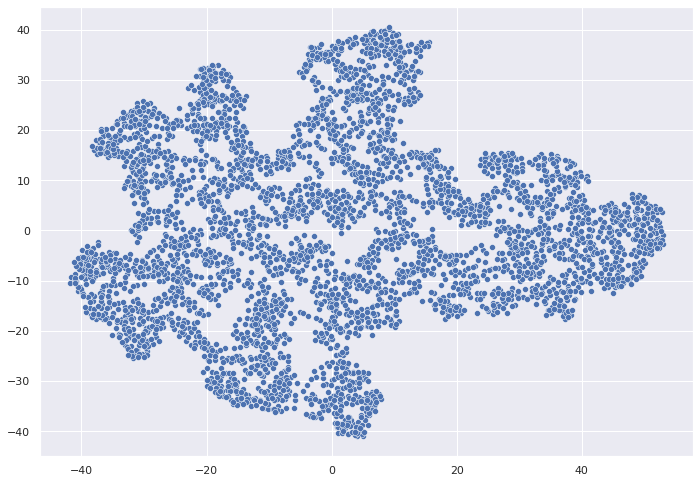

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    palette=palette
)
plt.show()